# 패키지 로딩 및 시드 설정

In [ ]:
# 데이터 로딩을 위해 코랩 사용
from google.colab import drive
drive.mount('/content/gdrive')

# 데이터 전처리를 위한 numpy와 pandas 사용
import numpy as np
import pandas as pd

# 그래프 시각화를 위해서 matplotlib 사용
import matplotlib.pyplot as plt
%matplotlib inline

# 에러 메세지 필터링을 위해서 warnings 를 사용
import warnings
warnings.filterwarnings('ignore')

# 시계열 데이터에서 추세를 제거하기 위해 fbprophet을 사용
!pip install fbprophet
from fbprophet import Prophet 

# 오토인코더를 사용하기 위해서 torch를 사용
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
import torch.nn as nn

# 랜덤시드를 1339로 고정
random_seed = 1339
SEED = 1339
torch.manual_seed(random_seed)
np.random.seed(random_seed)
import random
import os
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 데이터 불러오기

In [ ]:
# 데이터 불러오기
data=pd.read_csv("/content/gdrive/MyDrive/KT/data/IP/DHCP.csv") # 파트 1 : IP주제의 데이터인 DHCP.csv파일을 불러옴.

# 전처리 단계

## Timestamp 변경

In [ ]:
# Timestamp열의 데이터를 "-""를 기준으로 분리
time=data["Timestamp"].str.split("-", expand = True)

# Timestamp 데이터의 날짜에 해당하는 데이터를 date 리스트에 저장하고, 시간에 해당하는 데이터를 time 리스트에 저장함
time.drop(columns = [1], inplace = True)
time=time[0].str.split("_", expand = True)
date = time[[0]]
time = time[[1]]

# date 리스트를 year, month, day로 분리하여 각각 년, 월, 일을 저장
year = []
for i in range(len(date)) :
    year.append(date[0][i][0:4])

month = []
for i in range(len(date)) :
    month.append(date[0][i][4:6])

day = []
for i in range(len(date)) :
    day.append(date[0][i][6:8])

# time 리스트를 hour, min으로 분리하여 각각 시간, 분을 저장

hour = []
for i in range(len(date)) :
    hour.append(time[1][i][0:2])

min = []
for i in range(len(date)) :
    min.append(time[1][i][2:4])

# numpy의 datatime64의 형태(yyyy-mm-dd hh:mm:ss)로 모두 바꾸어줌

time_data = pd.DataFrame({'year':year,'month':month,'day':day, 'hour' : hour, 'min':min})
timestamp = time_data['year'] +"-" +time_data['month'] + "-" +time_data['day'] + " " + time_data['hour'] +":" + time_data["min"] + ":" + "00"
data["Timestamp"] = timestamp


## train/test split

In [ ]:
# month 리스트에 해당하는 값을 data의 month 열을 만들어서 저장함
data["month"] = month

In [ ]:
# month 열의 데이터 타입을 int(정수)로 변경
data["month"] = data["month"].astype(int)

In [ ]:
# 7월 이전의 데이터는 Train 데이터로, 7월 이후의 데이터는 Test 데이터로 지정
train=data[data["month"]<7]
test=data[data["month"]>=7]

## 보간

In [ ]:
# 시계열 데이터이므로, 결측치들을 시계열 날짜 index 기준으로 결측값을 보간

train.index = train["Timestamp"].astype("Datetime64")
train=train.drop(columns = ["Timestamp"])
train = train.interpolate(method = "time")
train = train.reset_index()

test.index = test["Timestamp"].astype("Datetime64")
test=test.drop(columns = ["Timestamp"])
test = test.interpolate(method = "time")
test = test.reset_index()

## 추세제거

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


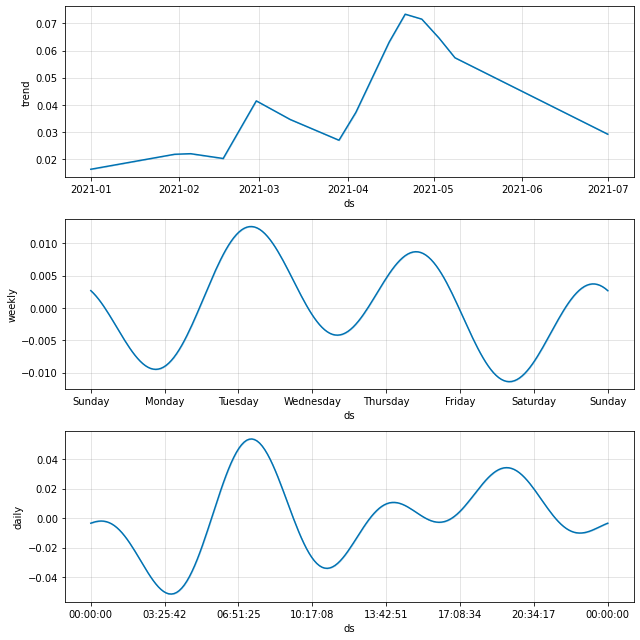

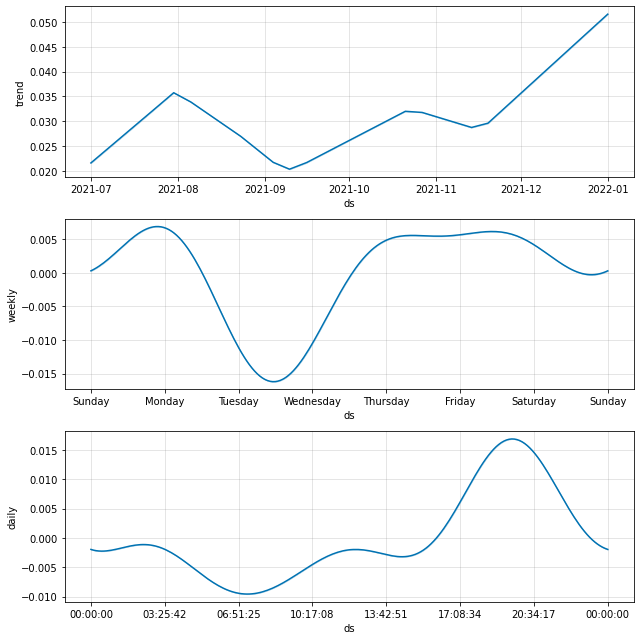

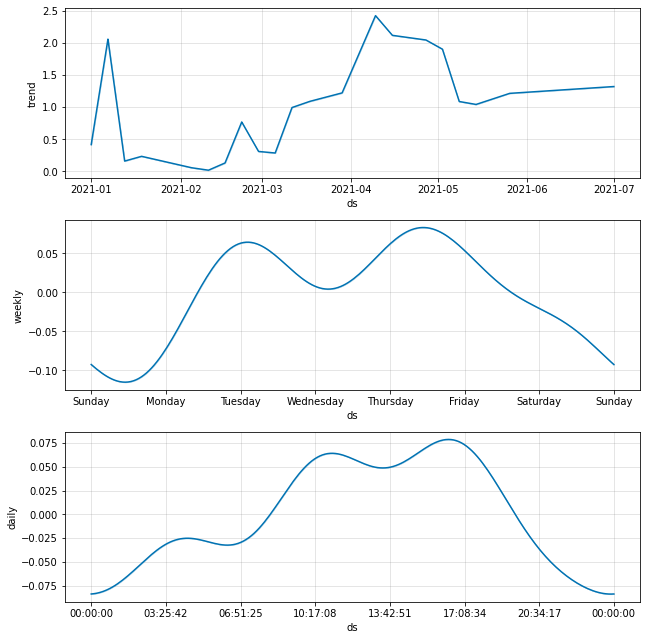

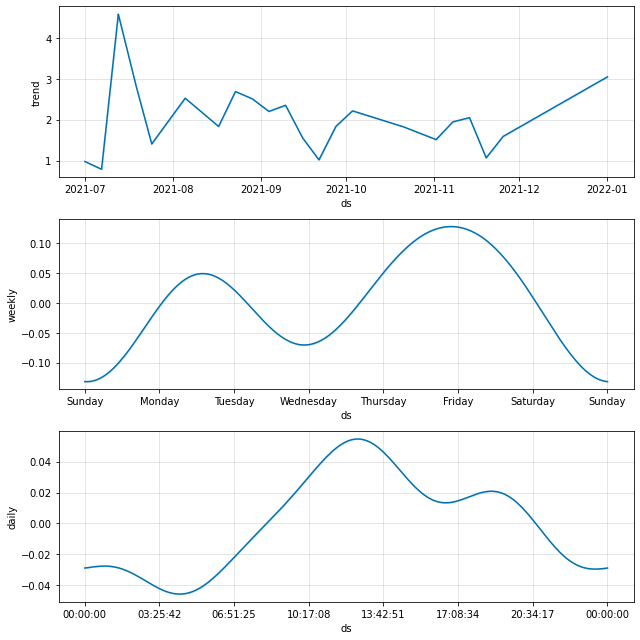

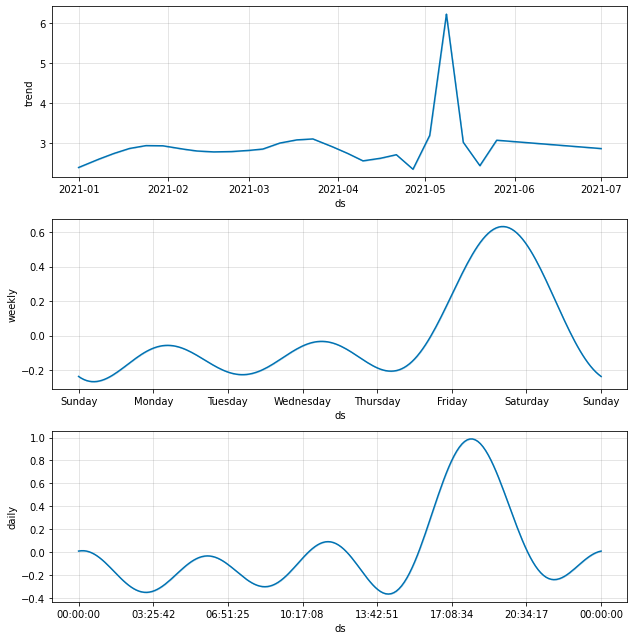

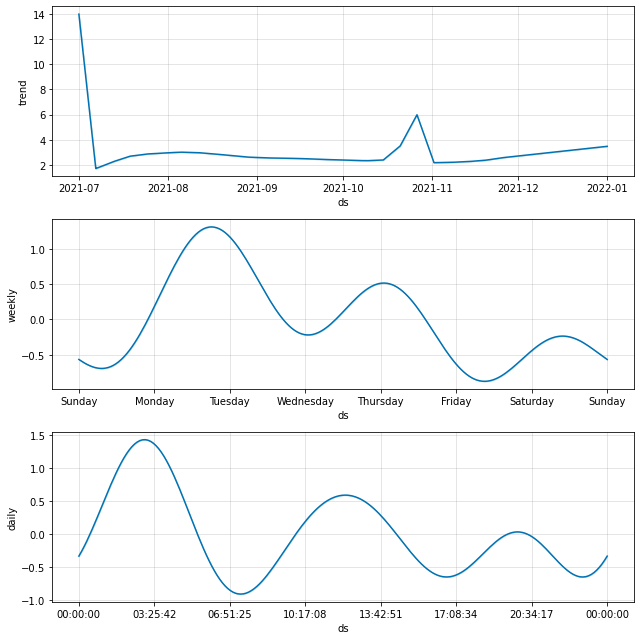

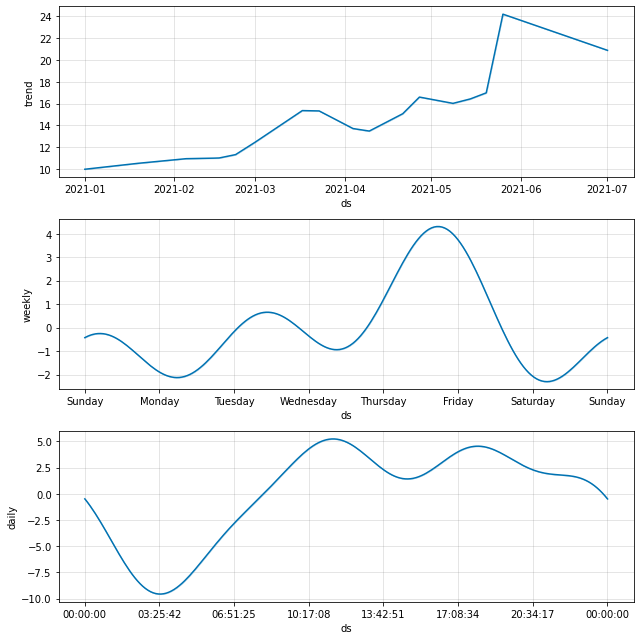

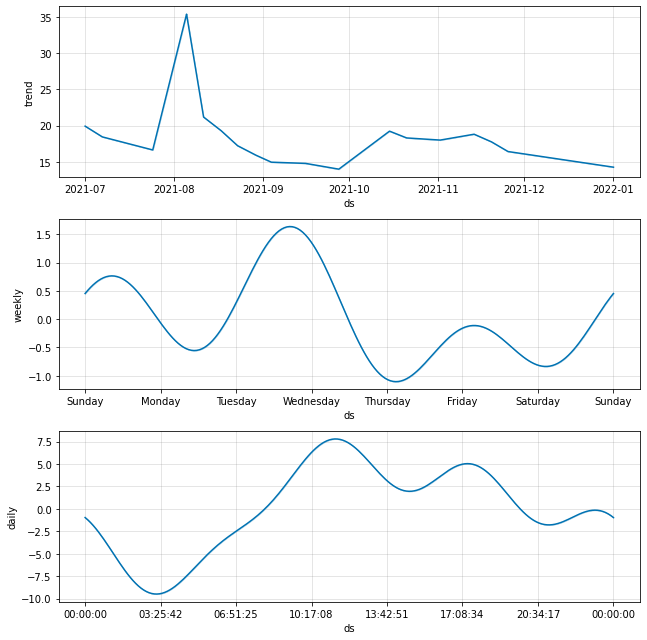

In [ ]:
# Prophet 모델에 적합시켜 train과 test의 각각의 열들에 대하여 추세를 제거
##### Svr_detect
Svr_detect = pd.concat([train['Timestamp'],train["Svr_detect"]],axis = 1)
Svr_detect = Svr_detect.rename(columns = {'Timestamp' : 'ds', "Svr_detect" : 'y'})
Svr_detect_model = Prophet()
Svr_detect_model.fit(Svr_detect)
Svr_detect_predict = Svr_detect_model.predict(pd.DataFrame(Svr_detect["ds"]))
Svr_detect["trend_off"]=Svr_detect['y'] - Svr_detect_predict['trend']

Svr_detect_test = pd.concat([test['Timestamp'],test["Svr_detect"]],axis = 1)
Svr_detect_test = Svr_detect_test.rename(columns = {'Timestamp' : 'ds', "Svr_detect" : 'y'})
Svr_detect_test_model = Prophet()
Svr_detect_test_model.fit(Svr_detect_test)
Svr_detect_test_predict = Svr_detect_test_model.predict(pd.DataFrame(Svr_detect_test["ds"]))
Svr_detect_test["trend_off"]=Svr_detect_test['y'] - Svr_detect_test_predict['trend']


##### Svr_connect
Svr_connect = pd.concat([train['Timestamp'],train["Svr_connect"]],axis = 1)
Svr_connect = Svr_connect.rename(columns = {'Timestamp' : 'ds', "Svr_connect" : 'y'})
Svr_connect_model = Prophet()
Svr_connect_model.fit(Svr_connect)
Svr_connect_predict = Svr_connect_model.predict(pd.DataFrame(Svr_connect["ds"]))
Svr_connect["trend_off"]=Svr_connect['y'] - Svr_connect_predict['trend']

Svr_connect_test = pd.concat([test['Timestamp'],test["Svr_connect"]],axis = 1)
Svr_connect_test = Svr_connect_test.rename(columns = {'Timestamp' : 'ds', "Svr_connect" : 'y'})
Svr_connect_test_model = Prophet()
Svr_connect_test_model.fit(Svr_connect_test)
Svr_connect_test_predict = Svr_connect_test_model.predict(pd.DataFrame(Svr_connect_test["ds"]))
Svr_connect_test["trend_off"]=Svr_connect_test['y'] - Svr_connect_test_predict['trend']


##### Ss_request
Ss_request = pd.concat([train['Timestamp'],train["Ss_request"]],axis = 1)
Ss_request = Ss_request.rename(columns = {'Timestamp' : 'ds', "Ss_request" : 'y'})
Ss_request_model = Prophet()
Ss_request_model.fit(Ss_request)
Ss_request_predict = Ss_request_model.predict(pd.DataFrame(Ss_request["ds"]))
Ss_request["trend_off"]=Ss_request['y'] - Ss_request_predict['trend']

Ss_request_test = pd.concat([test['Timestamp'],test["Ss_request"]],axis = 1)
Ss_request_test = Ss_request_test.rename(columns = {'Timestamp' : 'ds', "Ss_request" : 'y'})
Ss_request_test_model = Prophet()
Ss_request_test_model.fit(Ss_request_test)
Ss_request_test_predict = Ss_request_test_model.predict(pd.DataFrame(Ss_request_test["ds"]))
Ss_request_test["trend_off"]=Ss_request_test['y'] - Ss_request_test_predict['trend']



##### Ss_Established
Ss_Established = pd.concat([train['Timestamp'],train["Ss_Established"]],axis = 1)
Ss_Established = Ss_Established.rename(columns = {'Timestamp' : 'ds', "Ss_Established" : 'y'})
Ss_Established_model = Prophet()
Ss_Established_model.fit(Ss_Established)
Ss_Established_predict = Ss_Established_model.predict(pd.DataFrame(Ss_Established["ds"]))
Ss_Established["trend_off"]=Ss_Established['y'] - Ss_Established_predict['trend']

Ss_Established_test = pd.concat([test['Timestamp'],test["Ss_Established"]],axis = 1)
Ss_Established_test = Ss_Established_test.rename(columns = {'Timestamp' : 'ds', "Ss_Established" : 'y'})
Ss_Established_test_model = Prophet()
Ss_Established_test_model.fit(Ss_Established_test)
Ss_Established_test_predict = Ss_Established_test_model.predict(pd.DataFrame(Ss_Established_test["ds"]))
Ss_Established_test["trend_off"]=Ss_Established_test['y'] - Ss_Established_test_predict['trend']



# Svr_detect 시계열 분해 데이터 출력
Svr_detect_model.plot_components(Svr_detect_predict)
Svr_detect_test_model.plot_components(Svr_detect_test_predict)


# Svr_connect 시계열 분해 데이터 출력
Svr_connect_model.plot_components(Svr_connect_predict)
Svr_connect_test_model.plot_components(Svr_connect_test_predict)

# Ss_request 시계열 분해 데이터 출력
Ss_request_model.plot_components(Ss_request_predict)
Ss_request_test_model.plot_components(Ss_request_test_predict)

# Ss_Established 시계열 분해 데이터 출력
Ss_Established_model.plot_components(Ss_Established_predict)
Ss_Established_test_model.plot_components(Ss_Established_test_predict)


##### 추세 제거된 데이터로 대체

train['Svr_detect'] = Svr_detect['trend_off']
train['Svr_connect'] = Svr_connect['trend_off']
train['Ss_request'] = Ss_request['trend_off']
train['Ss_Established'] = Ss_Established['trend_off']

test['Svr_detect'] = Svr_detect_test['trend_off']
test['Svr_connect'] = Svr_connect_test['trend_off']
test['Ss_request'] = Ss_request_test['trend_off']
test['Ss_Established'] = Ss_Established_test['trend_off']

## 스케일러

In [ ]:
# MinMaxScaling 진행

train.drop(columns = ["Timestamp","month"],inplace = True)
test.drop(columns = ["Timestamp","month"],inplace = True)

data = pd.concat([train,test])
data = data.reset_index()
data.drop(columns = ["index"],inplace = True)

from sklearn.preprocessing import MinMaxScaler
model = MinMaxScaler()
model = model.fit(data)

train = model.transform(train)
test = model.transform(test)

## 텐서변환

In [ ]:
# 데이터 프레임 형태의 데이터를 텐서 형태의 데이터로 변환
train_data = torch.Tensor(np.array(train))
test_data = torch.Tensor(np.array(test))

# 모델 구현

## 모델 구성

In [ ]:
class Model(nn.Module) :
    def __init__(self, input_size, hidden_size, output_size) :
        super(Model, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # 인코더
        self.Encoder = nn.Sequential(
        
            nn.Linear(input_size,hidden_size[0]),
            nn.RReLU(),
            nn.Linear(hidden_size[0],output_size),
            nn.RReLU()
        )

        # 디코더
        self.Decoder = nn.Sequential(

            nn.Linear(output_size,hidden_size[0]),
            nn.RReLU(),
            nn.Linear(hidden_size[0],input_size)
        )

    # 전방 전달
    def forward(self, x) :
        x = self.Encoder(x)
        x = self.Decoder(x)

        return x

In [ ]:
# input_size, hidden_size, output_size 결정
input_size = 4
hidden_size = [3]
output_size = 2

# 모델 최종 구성
model = Model(input_size, hidden_size, output_size)
print(list(model.modules()))

[Model(
  (Encoder): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): Linear(in_features=3, out_features=2, bias=True)
    (3): RReLU(lower=0.125, upper=0.3333333333333333)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): Linear(in_features=3, out_features=4, bias=True)
  )
), Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
  (1): RReLU(lower=0.125, upper=0.3333333333333333)
  (2): Linear(in_features=3, out_features=2, bias=True)
  (3): RReLU(lower=0.125, upper=0.3333333333333333)
), Linear(in_features=4, out_features=3, bias=True), RReLU(lower=0.125, upper=0.3333333333333333), Linear(in_features=3, out_features=2, bias=True), RReLU(lower=0.125, upper=0.3333333333333333), Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): RReLU(lower=0.125, upper=0.333333333333

## 학습 함수

In [ ]:
# 손실함수를 MSE 함수를 사용

loss_function = nn.MSELoss()

def training(model, data,loss_function):

    # 옵티마이져는 Adam을 사용, learning rate는 0.01로 설정

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    

    # 데이터를 불러올 때, 배치사이즈는 64로 주고, shuffle = True로 설정하여 데이터를 뒤섞음
    dataloader = DataLoader(data, batch_size =64, shuffle =True)
    
    for epoch in range(1, 11): # 에포크는 10번 줌
        
        update_loss = 0.0
        
        for x in dataloader :
            optimizer.zero_grad()
            output = model(x)
            
            loss=loss_function(x, output) #dataloader로 불러온 데이터 값과 실제 데이터 간의 MSE 산출
            loss.backward()
            
            optimizer.step()
            update_loss += loss.item()

        print('epoch:', f'{epoch}', '  loss:', f'{update_loss}')
    
    return model

## 학습

In [ ]:
# 모델 학습
Model = training(model, train_data, loss_function)

epoch: 1   loss: 1.1663368161025573
epoch: 2   loss: 0.1277831489642267
epoch: 3   loss: 0.11090515549039992
epoch: 4   loss: 0.10971053906359884
epoch: 5   loss: 0.10993863553812844
epoch: 6   loss: 0.10982950053949025
epoch: 7   loss: 0.1096154835595371
epoch: 8   loss: 0.1101126072499028
epoch: 9   loss: 0.11040568714452093
epoch: 10   loss: 0.11048259888593748


In [ ]:
# 모델 저장
torch.save(Model.state_dict(),'/content/gdrive/MyDrive/model.pt')

## 임계값 설정

In [ ]:
# train 데이터의 손실값 구하기
train_loss = []
for data in train_data :
  output = Model(data)
  loss = loss_function(output, data)
  train_loss.append(loss.item())

# test 데이터의 손실값 구하기
test_loss = []
for data in test_data :
  output = Model(data)
  loss = loss_function(output, data)
  test_loss.append(loss.item())

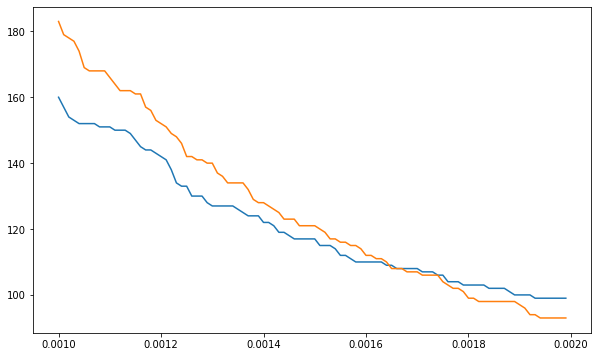

In [ ]:
# train 데이터와 test 데이터의 손실값의 갯수를 비교하기
train_len = []
test_len = []
index = np.arange(0.001, 0.002, 0.00001)
for i in np.arange(0.001, 0.002, 0.00001) :
    train_len_error = list(train_loss >= i)
    test_len_error = list(test_loss >= i)
    train_len.append(train_len_error.count(True))
    test_len.append(test_len_error.count(True))

plt.figure(figsize = (10,6))
plt.plot(index, train_len)
plt.plot(index, test_len)

In [ ]:
# 임계값을 설정하기

treshold = np.array(0.00131)
train_error = list(train_loss >= treshold)
test_error = list(test_loss >= treshold)

print("train_error : ",train_error.count(True))
print("test_error : ",test_error.count(True))

print("Threshold : ",treshold)

train_error :  127
test_error :  137
Threshold :  0.00131


## 임계값 확대

In [ ]:
###################### false가 난 구간 확인 #######################
submit = []
for i in range(len(test_loss)) :
    if test_loss[i] >= treshold :
        submit.append(1)
    else :
        submit.append(0)

submit = pd.DataFrame(submit)
submit=submit.rename(columns = {0:'Prediction'})

false = []
for i in range(len(submit)) :
    if submit["Prediction"][i] == 1:
         false.append(i)

false = list(false)


######### 오토인코더가 오류를 감지한 이후 1 시점에서 ################
######### 오류가 확정적으로 일어난다는 조건을 넣음 ##################
many = 1
false_plus = []
for i in range(len(false)) :
    false_plus.append(false[i] + many)

false_list = set(false) | set(false_plus)
false_list = list(false_list)
false_list.sort()


#################### 제출 ############################
submit_many = pd.DataFrame()
submit_many["Prediction"] = np.zeros(26496)

for i in false :
    submit_many["Prediction"][i] = 1

for i in false_list :
    submit_many["Prediction"][i] = 1

submit_many["Prediction"].value_counts()

0.0    26319
1.0      177
Name: Prediction, dtype: int64

## 결과도출

In [ ]:
submit_many.to_csv("/content/gdrive/MyDrive/part1_result.csv")